In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace

In [16]:
import os
import pickle
import argparse
import numpy as np
import pandas as pd
from pathlib import Path
import time
import matplotlib
import matplotlib.pyplot as plt
plt.ion()
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

from reacher_def import RotReacherEnv
import utils

In [5]:
### Use this in order to fuse several .pkl files in one folder into one
utils.fuse_dataframes('analysis/groundtruth_test')
data_raw = pd.read_pickle('analysis/groundtruth_test.pkl')

all_types = data_raw['type'].unique()
all_n = data_raw['n_batch'].unique()
all_horizons = data_raw['horizon'].unique()
all_generations = data_raw['n_generations'].unique()
all_timepoints = data_raw['timepoint'].unique()
all_experiments = data_raw['experiment'].unique()

names = ['type', 'n_batch', 'horizon', 'n_generations', 'experiment', 'timepoint']
mind = pd.MultiIndex.from_product(
    [all_types, all_n, all_horizons, all_generations, all_experiments, all_timepoints], names=names)
data_raw = data_raw.set_index(names).reindex(mind).reset_index()
data_raw.to_pickle('analysis/groundtruth_test.pkl')

Reading files in analysis/groundtruth_test ...
Finished. Saved fused file groundtruth_test in analysis.


In [9]:
def plot_cumulative_error(filename=None, save_dir=None):
    if filename is None:
        filename = 'groundtruth_test.pkl'
    try:
        if save_dir is None:
            save_dir = os.path.join('analysis', filename)
        data_raw = pd.read_pickle(save_dir)    
    except:
        print('Could not find file {}'.format(save_dir))
        return
    
    data = data_raw.groupby(['type', 'n_batch', 'horizon', 'n_generations', 'experiment'])[["error (cm)"]].sum()
    data = data.reset_index()
    data['horizon'] = data['horizon'].astype(str) + '_'
    data.rename(columns={'n_generations':'# generations',
                                'n_batch':'batch size',
                                'type':'distribution type',
                                'error (cm)': 'cumulative error (cm)'}, inplace=True)

    g = sns.relplot(x='# generations', 
                    y='cumulative error (cm)', 
                    hue='horizon', 
                    style='batch size', 
                    col='distribution type', 
                    height=5, 
                    kind='line', 
                    data=data)
    return g.fig

def plot_trajectories(filename=None, save_dir=None):
    if filename is None:
        filename = 'groundtruth_test.pkl'
    try:
        if save_dir is None:
            save_dir = os.path.join('analysis', filename)
        data_raw = pd.read_pickle(save_dir)    
    except:
        print('Could not find file {}'.format(save_dir))
        return
    
    data_traj = data_raw.groupby(['horizon', 'timepoint'])[['x (cm)', 'y (cm)']].mean()
    data_traj = data_traj.reset_index()
    data_traj['horizon'] = data_traj['horizon'].astype(str) + '_'
    fig , ax = plt.subplots(figsize=(20, 5))
    g = sns.lineplot(x="x (cm)", y="y (cm)", hue="horizon", data=data_traj)
    g.set_xlim([0, 10])
    g.set_ylim([-3, 3])
    
    goal_reg = plt.Circle([8, 0], 1.6, edgecolor='k', fill=False, linewidth=4, alpha=0.5)
    g.add_artist(goal_reg)
    
    data_endpoint = data_raw.groupby(['horizon', 'experiment', 'timepoint']).agg('mean')
    data_endpoint = data_endpoint.reset_index().loc[data_endpoint.reset_index().groupby(['horizon', 'experiment'])['timepoint'].idxmax()]
    means = data_endpoint.groupby(['horizon']).agg('mean')[['x (cm)', 'y (cm)']].values
    stds = data_endpoint.groupby(['horizon']).agg('std')[['x (cm)', 'y (cm)']].values
    color_palette = sns.color_palette()
    for k in range(means.shape[0]):
        end_point = matplotlib.patches.Ellipse(means[k], stds[k,0], stds[k,1], 
                                               edgecolor=color_palette[k], facecolor=color_palette[k], alpha=0.3)
        g.add_artist(end_point)
    
    g.set_aspect('equal')
    g.legend(loc='upper left')
    plt.tight_layout()
    return fig

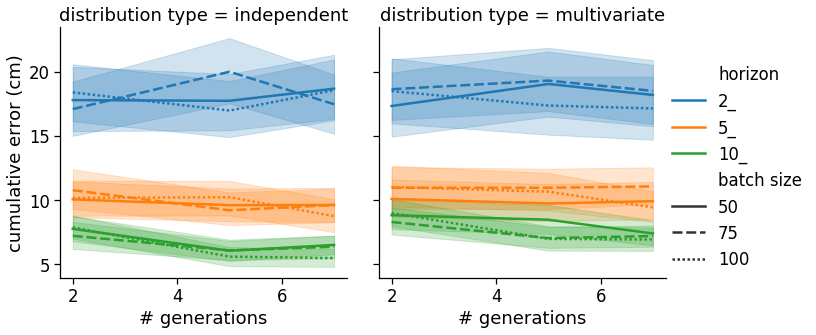

In [17]:
fig_cum_error = plot_cumulative_error()

In [11]:
fig_cum_error.savefig('figures/planner_cum_error.pdf', format='pdf')
fig_cum_error.savefig('figures/planner_cum_error.eps', format='eps')